In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
from random import randint
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_CNA/Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_Mutation_CNA/Predictions/"
em_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_Mutation/Predictions/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_CNA/Predictions/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_CNA/Figures/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent
,TOTAL:,1001,996,968,957,990,,,,,,


In [6]:
# change directory to read GDSC expression dataset (EGFRi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (EGFRi) 

GDSCE = pd.read_csv("GDSC_exprs.z.EGFRi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
683667,0.8924335646616343,-0.2118047645974752,-1.5249963829654445,-0.5512338119420259,-0.1375180480622428,-0.5276262991742051,-0.0305604198225781,0.5226216566753464,0.4877783097403741,0.2252883573642275,...,-0.0156845434045267,-0.1612071417519457,1.2033249282722671,2.7714836839186687,-0.3165072496327769,-0.8849200030571541,-0.5104734344593952,0.2984361940989172,-0.4349407065496763,0.4747633022523675
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [8]:
# change directory to read GDSC CNA dataset (EGFRi)

os.chdir(dataset_dir + "/CNA/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA


In [9]:
# read GDSC CNA dataset (EGFRi)

GDSCC = pd.read_csv("GDSC_CNA.EGFRi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCC.drop_duplicates(keep='last')
GDSCC = pd.DataFrame.transpose(GDSCC)
GDSCC = GDSCC.loc[:, ~GDSCC.columns.duplicated()]

GDSCC.head()

gene_id,1,2,9,10,12,13,14,15,16,18,...,107985535,107985759,107986588,107986809,107986898,107987337,107987341,109731405,112441434,121676927
683665,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00,1.807355,0.000000,0.000000,0.000000
683667,0.000000,0.0,0.321928,0.321928,-1.000000,-0.415037,0.0,0.0,-0.415037,-0.415037,...,-0.415037,-0.415037,0.000000,0.0,0.321928,0.00,-1.000000,-0.415037,0.000000,0.321928
684057,-0.415037,0.0,0.584963,0.584963,-1.000000,0.000000,0.0,0.0,-0.415037,-0.415037,...,-0.415037,0.000000,0.000000,0.0,0.807355,-1.00,-1.000000,-0.415037,-0.415037,0.807355
684059,0.000000,0.0,0.000000,0.000000,0.000000,0.415037,0.0,0.0,0.000000,0.415037,...,0.000000,0.000000,0.415037,0.0,0.415037,-4.32,-4.320000,0.000000,0.000000,0.736966
684062,-0.415037,0.0,0.321928,0.321928,-0.415037,-0.415037,0.0,0.0,-0.415037,0.000000,...,-0.415037,0.000000,0.000000,0.0,0.321928,-4.32,-4.320000,-0.415037,-1.000000,0.321928


In [10]:
# change directory to read GDSC response dataset (EGFRi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (EGFRi)

GDSCR = pd.read_csv("GDSC_response.EGFRi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,1.49001536063508,Afatinib,1,1,1
683665,0,3.70042086392846,Afatinib (rescreen),1,1,1
683665,0,6.29444657935625,Cetuximab,1,1,1
683665,0,-1.50094791622811,CUDC-101,1,1,1
683665,1,-0.966773876200563,EKB-569,1,1,1


In [12]:
# print count of cell lines for each drug (EGFRi)

GDSCR["drug"].value_counts()

drug
EKB-569                770
Afatinib (rescreen)    757
CUDC-101               754
Afatinib               738
Gefitinib              734
Cetuximab              725
HG-5-88-01             422
Lapatinib              371
Erlotinib              362
Name: count, dtype: int64

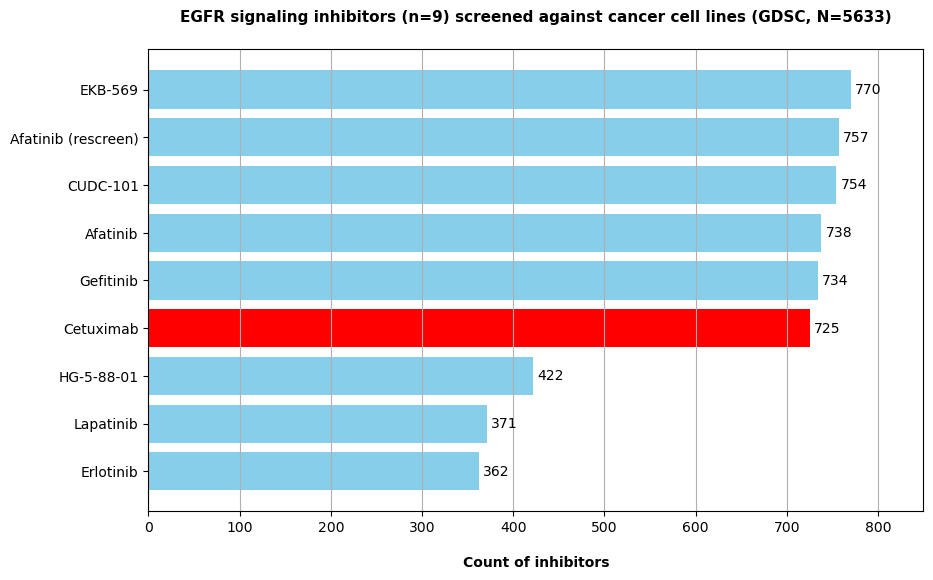

In [13]:
# plot EGFR signaling inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Cetuximab":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'EGFR signaling inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'EGFR Signaling Inhibitors with Their Counts (GDSC, Cetuximab).png', format='png', bbox_inches='tight')

plt.show()

In [14]:
# change directory to read PDX expression dataset homogenized with GDSC expression dataset (Cetuximab)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read PDX expression dataset homogenized with GDSC expression dataset (Cetuximab)

PDXEcetuximab = pd.read_csv("PDX_exprs.Cetuximab.eb_with.GDSC_exprs.Cetuximab.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEcetuximab = pd.DataFrame.transpose(PDXEcetuximab)
PDXEcetuximab.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1027,3.60061063639454,3.07817969365007,6.32765157689639,2.93005596217687,2.64304491832882,2.56618657438719,8.09168714940745,2.55483284192774,8.59989127217117,2.80664192172726,...,2.5997416042245,3.06591431154376,5.50994883395808,2.93037262394265,2.93460472043208,2.44987572619243,2.48989773232543,3.88458609037183,3.95227909263729,2.46055443755884
X-1119,3.54613916595946,3.07817969365007,7.46956729139981,4.20521626673769,2.929569339555,5.57576806896234,8.20319464923893,2.41443776874882,7.7754694329959,3.34200309260696,...,2.67274979347372,3.11395605082,8.98094314882696,2.93037262394265,2.93460472043208,2.44987572619243,2.48989773232543,4.81457724903364,3.95227909263729,2.84309989182372
X-1156,6.99909567844156,8.47130432034951,6.15135176832441,2.36952374925443,3.6713478754664,2.53437362934482,8.43809032488933,2.53376073162296,7.11948011162002,3.28816715734563,...,2.72150643954151,3.17396413482904,6.58328775150283,2.93037262394265,2.93460472043208,2.44987572619243,2.48989773232543,4.74727922278015,4.15062701412473,2.46987656241725


In [16]:
# change directory to read PDX CNA dataset (Cetuximab)

os.chdir(dataset_dir + "CNA")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA'

In [17]:
# read PDX CNA dataset (Cetuximab)

PDXCcetuximab = pd.read_csv("PDX_CNA.Cetuximab.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXCcetuximab.drop_duplicates(keep='last')
PDXCcetuximab = pd.DataFrame.transpose(PDXCcetuximab)
PDXCcetuximab = PDXCcetuximab.loc[:, ~PDXCcetuximab.columns.duplicated()]

PDXCcetuximab.head(3)

ENTREZID,1,2,3,9,10,12,13,14,15,16,...,101340252,102723547,102724473,103091865,105375355,107126285,109623460,109731405,118126072,128385369
X-1027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.1844245711374275,0.0,0.0,0.0,0.0
X-1119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.7311832415721999,0.0,0.0,0.0,0.4276061727818994,0.0
X-1156,0.9781956296816516,0.7004397181410922,0.7004397181410922,-0.2429767534925404,-0.2429767534925404,-0.2863041851566411,0.5607149544744789,0.3895668117627256,-0.2688167584278,-0.2688167584278,...,0.4594316186372972,0.0,-0.4246876693125631,-0.7369655941662062,0.0,1.100977647724821,-0.3770696490798233,-0.3219280948873623,-0.6551715030025588,0.0


In [18]:
# variance threshold for GDSC Expression dataset (EGFRi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [19]:
# fill NA values and binarize GDSC CNA dataset (EGFRi)

GDSCC = GDSCC.fillna(0)
GDSCC[GDSCC != 0.0] = 1

In [20]:
# select shared genes between GDSC and PDX expression and CNA datasets 

ls = GDSCE.columns.intersection(GDSCC.columns)
ls = ls.intersection(PDXEcetuximab.columns)
ls = ls.intersection(PDXCcetuximab.columns)

ls = pd.unique(ls)

print(f"GDSC and PDX # of common genes: {ls.shape[0]}")

GDSC and PDX # of common genes: 17901


In [21]:
# select shared samples between GDSC expression and response datasets (EGFRi)

ls2 = GDSCE.index.intersection(GDSCC.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 800


In [22]:
# subset shared genes and samples in GDSC expression, CNA, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCC = GDSCC.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCC.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

# There exists same sample names for different drugs, so row shape is different in GDSC response data

GDSC # of common samples and genes (Expression): (800, 17901)
GDSC # of common samples and genes (CNA): (800, 17901)
GDSC # of samples (Response): 5633


In [23]:
# select shared samples between PDX expression and CNA datasets (Cetuximab) 

ls3 = PDXEcetuximab.index.intersection(PDXCcetuximab.index)

print(f"PDX # of common samples (Cetuximab): {ls3.shape[0]}")

PDX # of common samples (Cetuximab): 60


In [24]:
# select shared genes and samples between PDX expression and CNA datasets (Cetuximab)

PDXEcetuximab = PDXEcetuximab.loc[ls3, ls]
PDXCcetuximab = PDXCcetuximab.loc[ls3, ls]

print(f"PDX # of common samples and genes for Expression (Cetuximab): {PDXEcetuximab.shape}")
print(f"PDX # of common samples and genes for CNA (Cetuximab): {PDXCcetuximab.shape}\n")

PDX # of common samples and genes for Expression (Cetuximab): (60, 17901)
PDX # of common samples and genes for CNA (Cetuximab): (60, 17901)



In [25]:
# change directory to read DEGs (EGFRi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi


In [26]:
# read DEGs (EGFRi)

DEGs_filtered_data = pd.read_excel("EGFRi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among EGFR signaling inhibitors\n")

DEGs_filtered_data.head()

There are 1028 DEGs (p-adjusted < 0.05 and |logFC| > 1) among EGFR signaling inhibitors



,Gene Symbol,Frequency
0,MYOF,9
1,TM4SF1,8
2,KRT18,8
3,WWC1,8
4,CAV1,8


In [27]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id.shape[0]
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CLECL1P', 2), ('CAST', 2)]
1 input query terms found no hit:	['SLC22A18']


1028

In [28]:
# assign GDSC data to new variables

exprs_z = GDSCE
cna = GDSCC
responses = GDSCR

In [29]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,1.49001536063508,Afatinib,1,1,1
683665,0,3.70042086392846,Afatinib (rescreen),1,1,1
683665,0,6.29444657935625,Cetuximab,1,1,1


In [30]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'Afatinib',
 'Afatinib (rescreen)',
 'CUDC-101',
 'Cetuximab',
 'EKB-569',
 'Erlotinib',
 'Gefitinib',
 'HG-5-88-01',
 'Lapatinib'}

In [31]:
# convert Entrez gene IDs to integer

responses.index = responses.index.astype(int)
responses.index

Index([683665, 683665, 683665, 683665, 683665, 683665, 683665, 683665, 683665,
       683667,
       ...
       910930, 910941, 910941, 924248, 924248, 924248, 906849, 906849, 949162,
       949162],
      dtype='int64', length=5633)

In [32]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
#dat.head()

GDSC\nTissue descriptor 1
lung_NSCLC           594
leukemia             538
urogenital_system    531
lymphoma             487
aero_dig_tract       408
nervous_system       369
lung_SCLC            347
skin                 334
breast               299
large_intestine      279
digestive_system     268
bone                 261
neuroblastoma        212
pancreas             154
kidney               138
myeloma              113
soft_tissue          112
lung                  99
thyroid               90
Name: count, dtype: int64

In [33]:
# list count of cell lines as to tissues treated with cetuximab

filter = (dat["drug"] == "Cetuximab")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
lung_NSCLC           87
urogenital_system    76
leukemia             66
lymphoma             56
aero_dig_tract       56
nervous_system       47
skin                 44
breast               41
lung_SCLC            39
digestive_system     37
bone                 34
large_intestine      33
pancreas             20
kidney               19
neuroblastoma        19
soft_tissue          16
myeloma              13
lung                 11
thyroid              11
Name: count, dtype: int64

In [34]:
# list count of cell lines as to tissues treated with cetuximab

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    366
lung_small_cell_carcinoma    347
glioma                       341
melanoma                     311
breast                       299
Name: count, dtype: int64

In [35]:
# count of CRC and NSCLC samples

tissues = dat["GDSC\nTissue\ndescriptor 2"].value_counts()
count_selected_tissues = tissues["large_intestine"].astype(int) + \
                         tissues["lung_NSCLC_adenocarcinoma"].astype(int) + \
                         tissues["lung_NSCLC_large cell"].astype(int) + \
                         tissues["lung_NSCLC_squamous_cell_carcinoma"].astype(int) + \
                         tissues["lung_NSCLC_not specified"].astype(int) + \
                         tissues["lung_NSCLC_carcinoid"].astype(int) 
count_selected_tissues

873

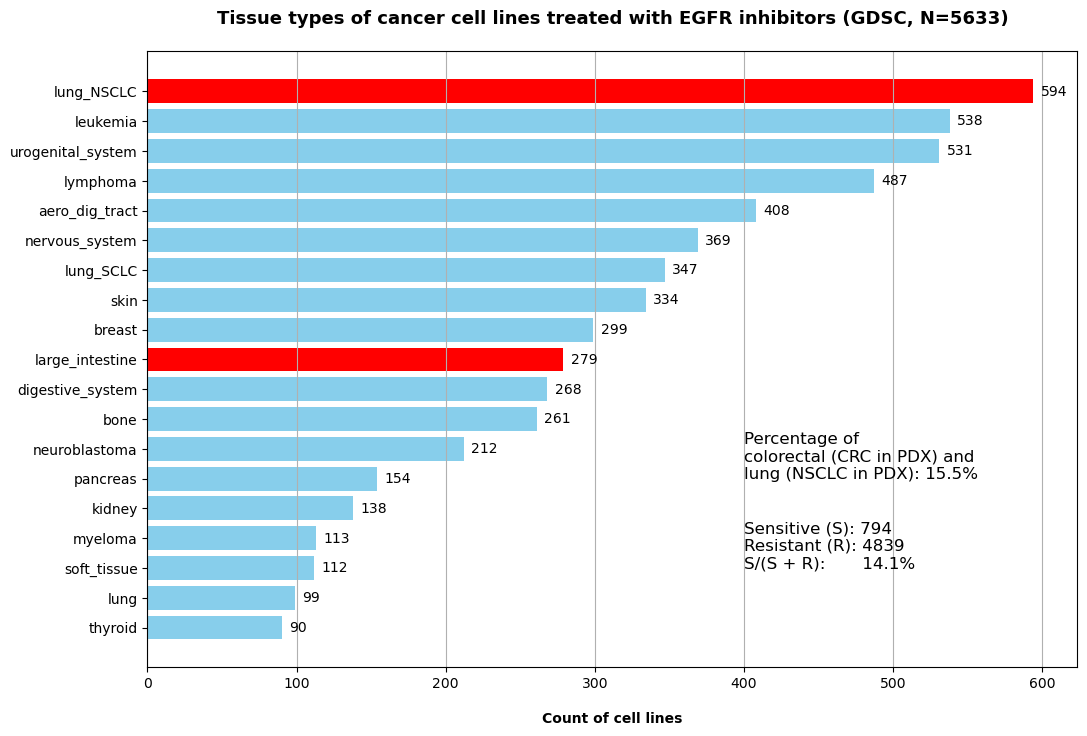

In [36]:
# plot tissue types of cancer cell lines treated with EGFR signaling inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with EGFR inhibitors (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "large_intestine" or name == "lung_NSCLC":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(400, 13, 
         f'Percentage of \ncolorectal (CRC in PDX) and \nlung (NSCLC in PDX): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(400, 16, 
         f'Sensitive (S): {dat[["response"]].value_counts()[1]} \nResistant (R): {dat[["response"]].value_counts()[0]} \nS/(S + R):       {round(dat[["response"]].value_counts()[1]/(sum(dat[["response"]].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')


plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with EGFR inhibitors (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [37]:
# list count of cell lines as to tissues treated with cetuximab

filter = (dat["drug"] == "Cetuximab")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
lung_NSCLC           87
urogenital_system    76
leukemia             66
lymphoma             56
aero_dig_tract       56
nervous_system       47
skin                 44
breast               41
lung_SCLC            39
digestive_system     37
bone                 34
large_intestine      33
pancreas             20
kidney               19
neuroblastoma        19
soft_tissue          16
myeloma              13
lung                 11
thyroid              11
Name: count, dtype: int64

In [38]:
# list count of cell lines as to tissues treated with cetuximab

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Cetuximab")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    54
glioma                       44
breast                       41
melanoma                     41
lung_small_cell_carcinoma    39
Name: count, dtype: int64

In [39]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683667',
       ...
       '910930', '910941', '910941', '924248', '924248', '924248', '906849',
       '906849', '949162', '949162'],
      dtype='object', length=5633)

In [40]:
# filter GDSC expression and CNA datasets (EGFRi) as to drugs
# subset selected DEGs

expression_zscores = []
CNA = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    c = cna.loc[samples, :]
    expression_zscores.append(e_z)
    CNA.append(c)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCCv2 = pd.concat(CNA, axis=0)
GDSCRv2 = responses

ls4 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls5 = GDSCEv2.index.intersection(GDSCCv2.index)

GDSCEv2 = GDSCEv2.loc[ls5, ls4]
GDSCCv2 = GDSCCv2.loc[ls5, ls4]
GDSCRv2 = GDSCRv2.loc[ls5, :]

PDXEcetuximab= PDXEcetuximab.loc[:,ls4]
PDXCcetuximab = PDXCcetuximab.loc[:,ls4]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCCv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Cetuximab (Expression): {PDXEcetuximab.shape}")
print(f"PDX # of common samples and genes for Cetuximab (CNA): {PDXCcetuximab.shape}\n")

GDSC # of common samples and genes (Expression): (5633, 1019)
GDSC # of common samples and genes (CNA): (5633, 1019)
GDSC # of common samples (Response): 5633

PDX # of common samples and genes for Cetuximab (Expression): (60, 1019)
PDX # of common samples and genes for Cetuximab (CNA): (60, 1019)



In [41]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 0 0]


In [42]:
# change directory to read PDX response dataset (Cetuximab)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [43]:
# read PDX response dataset (Cetuximab)

PDXRcetuximab = pd.read_csv("PDX_response.Cetuximab.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRcetuximab.dropna(inplace=True)
PDXRcetuximab.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRcetuximab["response"] = PDXRcetuximab.loc[:, "response"].apply(lambda x: d[x])
Ytscetuximab = PDXRcetuximab["response"].values    

print(f"There are {Ytscetuximab.shape[0]} samples with response data in the PDX (Cetuximab)\n")
Ytscetuximab

There are 60 samples with response data in the PDX (Cetuximab)



array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [44]:
# merged PDX cohort table with PDX response dataset (Cetuximab)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "cetuximab",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-0933,CRC
X-1027,CRC
X-1055,CRC
X-1119,CRC
X-1156,NSCLC


In [45]:
# merged PDX cohort table with PDX response dataset (Cetuximab)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRcetuximab,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
CRC      36
NSCLC    24
Name: count, dtype: int64

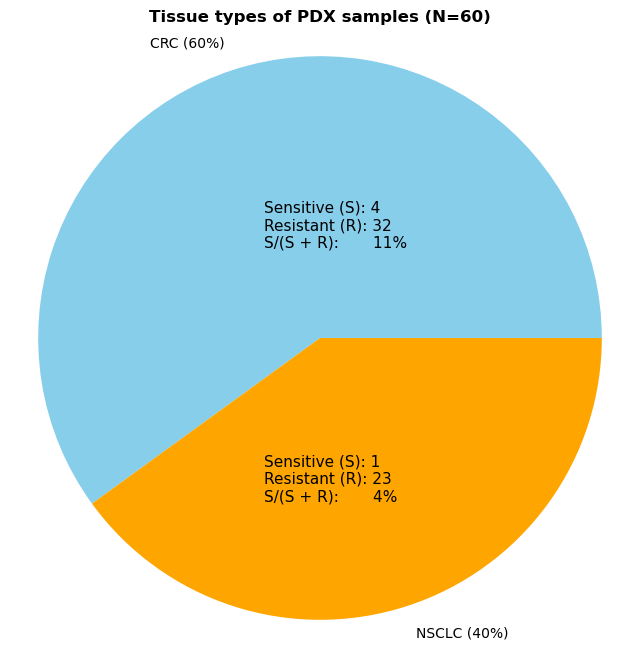

In [46]:
# plot tissue types of PDX samples (Cetuximab)

labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_percentages, startangle=0, colors=['skyblue','orange'])
plt.title(f'Tissue types of PDX samples (N={total})', fontweight = "bold")
plt.axis('equal')  

plt.text(-0.2, 0.4, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts())) * 100, 2).astype(int)}%', 
         fontsize=11, 
         color='black',
         va='center')

plt.text(-0.2, -0.5, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts())) * 100, 2).astype(int)}%', 
         fontsize=11, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of PDX samples (Cetuximab).png', format='png', bbox_inches='tight')

plt.show()

In [47]:
# filter CRC cohort samples (Cetuximab)

filter = (dat_pdx["Tumor Type"] == "CRC")
pdx_crc_samples = dat_pdx.loc[filter,].index
pdx_crc_samples

Index(['X-1027', 'X-1119', 'X-1167', 'X-1173', 'X-1270', 'X-1290', 'X-1303',
       'X-1329', 'X-1443', 'X-1479', 'X-1500', 'X-1536', 'X-1538', 'X-2145',
       'X-2182', 'X-2239', 'X-2403', 'X-2483', 'X-2484', 'X-2538', 'X-2573',
       'X-2659', 'X-2822', 'X-2846', 'X-2861', 'X-3093', 'X-3205', 'X-3224',
       'X-3671', 'X-3792', 'X-4087', 'X-5254', 'X-5405', 'X-5446', 'X-5495',
       'X-5578'],
      dtype='object')

In [48]:
# filter responses of CRC cohort samples (Cetuximab)

Ytscetuximab_crc = PDXRcetuximab.loc[pdx_crc_samples,"response"].values
Ytscetuximab_crc

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [49]:
# count of sensitive and resistance NSCLC samples (Cetuximab)

PDXRcetuximab.loc[pdx_crc_samples,"response"].value_counts()

response
0    32
1     4
Name: count, dtype: int64

In [50]:
# filter NSCLC cohort samples (Cetuximab)

filter = (dat_pdx["Tumor Type"] == "NSCLC")
pdx_nsclc_samples = dat_pdx.loc[filter,].index
pdx_nsclc_samples

Index(['X-1156', 'X-1172', 'X-1323', 'X-1442', 'X-1499', 'X-1586', 'X-1658',
       'X-1725', 'X-1787', 'X-1823', 'X-1834', 'X-1835', 'X-1934', 'X-1980',
       'X-1993', 'X-2017', 'X-2042', 'X-2082', 'X-2088', 'X-2094', 'X-3029',
       'X-3237', 'X-3843', 'X-4819'],
      dtype='object')

In [51]:
# filter responses of NSCLC cohort samples (Cetuximab)

Ytscetuximab_nsclc = PDXRcetuximab.loc[pdx_nsclc_samples,"response"].values
Ytscetuximab_nsclc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

In [52]:
# count of sensitive and resistance NSCLC samples (Cetuximab)

PDXRcetuximab.loc[pdx_nsclc_samples,"response"].value_counts()

response
0    23
1     1
Name: count, dtype: int64

In [53]:
# define maximum iteration

max_iter = 50

In [54]:
# assign number of neurons and dropout rates found for layers from the saved models

hdm1 = 512
hdm2 = 256
rate1 = 0.5
rate2 = 0.8
rate3 = 0.8

In [55]:
# load pre-trained modules and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEcetuximab= scalerGDSC.transform(PDXEcetuximab.values) 
X_testEcetuximab_crc = scalerGDSC.transform(PDXEcetuximab.loc[pdx_crc_samples,].values) 
X_testEcetuximab_nsclc = scalerGDSC.transform(PDXEcetuximab.loc[pdx_nsclc_samples,].values) 

X_trainC = np.nan_to_num(GDSCCv2.values)
X_testCcetuximab = np.nan_to_num(PDXCcetuximab.values.astype(np.float32))
X_testCcetuximab_crc = np.nan_to_num(PDXCcetuximab.loc[pdx_crc_samples,].values.astype(np.float32))
X_testCcetuximab_nsclc = np.nan_to_num(PDXCcetuximab.loc[pdx_nsclc_samples,].values.astype(np.float32))

TX_testEcetuximab= torch.FloatTensor(X_testEcetuximab)
TX_testEcetuximab_crc = torch.FloatTensor(X_testEcetuximab_crc)
TX_testEcetuximab_nsclc = torch.FloatTensor(X_testEcetuximab_nsclc)

TX_testCcetuximab = torch.FloatTensor(X_testCcetuximab.astype(np.float32))
TX_testCcetuximab_crc = torch.FloatTensor(X_testCcetuximab_crc.astype(np.float32))
TX_testCcetuximab_nsclc = torch.FloatTensor(X_testCcetuximab_nsclc.astype(np.float32))

ty_testEcetuximab= torch.FloatTensor(Ytscetuximab.astype(int))
ty_testEcetuximab_crc = torch.FloatTensor(Ytscetuximab_crc.astype(int))
ty_testEcetuximab_nsclc = torch.FloatTensor(Ytscetuximab_nsclc.astype(int))


n_sampE, IE_dim = X_trainE.shape
n_sampC, IC_dim = X_trainC.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2 

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()
        self.EnC = torch.nn.Sequential(
            nn.Linear(IC_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnC(x)
        return output       

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA.pt")
AutoencoderC = torch.load(models_dir + "CNA_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA.pt")

Clas = torch.load(models_dir + "Class_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA.pt")

AutoencoderE.eval()
AutoencoderC.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZCX = AutoencoderC(torch.FloatTensor(X_trainC))
ZTX = torch.cat((ZEX, ZCX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUC (PDX_EGFRi): {round(AUCT,2)}")
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUCPR (PDX_EGFRi): {round(AUCTaucpr,2)}\n")

ZETcetuximab = AutoencoderE(TX_testEcetuximab)
ZCTcetuximab = AutoencoderC(TX_testCcetuximab)
ZTTcetuximab = torch.cat((ZETcetuximab, ZCTcetuximab), 1)
ZTTcetuximab = F.normalize(ZTTcetuximab, p=2, dim=0)
PredTcetuximab = Clas(ZTTcetuximab)
AUCTcetuximab = roc_auc_score(Ytscetuximab.astype(int), PredTcetuximab.detach().numpy())
#print(f"PDX - Test AUC (Cetuximab): {round(AUCTcetuximab,2)}")
AUCTcetuximab_aucpr = average_precision_score(Ytscetuximab.astype(int), PredTcetuximab.detach().numpy())
#print(f"PDX - Test AUCPR (Cetuximab): {round(AUCTcetuximab_aucpr,2)}\n")

ZETcetuximab_crc = AutoencoderE(TX_testEcetuximab_crc)
ZCTcetuximab_crc = AutoencoderC(TX_testCcetuximab_crc)
ZTTcetuximab_crc = torch.cat((ZETcetuximab_crc, ZCTcetuximab_crc), 1)
ZTTcetuximab_crc = F.normalize(ZTTcetuximab_crc, p=2, dim=0)
PredTcetuximab_crc = Clas(ZTTcetuximab_crc)
AUCTcetuximab_crc = roc_auc_score(Ytscetuximab_crc.astype(int), PredTcetuximab_crc.detach().numpy())
#print(f"PDX - Test AUC (cet, CRC): {round(AUCTcetuximab_crc,2)}")
AUCTcetuximab_crc_aucpr = average_precision_score(Ytscetuximab_crc.astype(int), PredTcetuximab_crc.detach().numpy())
#print(f"PDX - Test AUCPR (cet, CRC): {round(AUCTcetuximab_crc_aucpr,2)}\n")

ZETcetuximab_nsclc = AutoencoderE(TX_testEcetuximab_nsclc)
ZCTcetuximab_nsclc = AutoencoderC(TX_testCcetuximab_nsclc)
ZTTcetuximab_nsclc = torch.cat((ZETcetuximab_nsclc, ZCTcetuximab_nsclc), 1)
ZTTcetuximab_nsclc = F.normalize(ZTTcetuximab_nsclc, p=2, dim=0)
PredTcetuximab_nsclc = Clas(ZTTcetuximab_nsclc)
AUCTcetuximab_nsclc = roc_auc_score(Ytscetuximab_nsclc.astype(int), PredTcetuximab_nsclc.detach().numpy())
#print(f"PDX - Test AUC (cet, NSCLC): {round(AUCTcetuximab_nsclc,2)}")
AUCTcetuximab_nsclc_aucpr = average_precision_score(Ytscetuximab_nsclc.astype(int), PredTcetuximab_nsclc.detach().numpy())
#print(f"PDX - Test AUCPR (cet, NSCLC): {round(AUCTcetuximab_nsclc_aucpr,2)}\n")

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTcetuximab_finetuned = dict()
AUCTcetuximab_crc_finetuned = dict()
AUCTcetuximab_nsclc_finetuned = dict()
AUCTcetuximab_aucpr_finetuned = dict()
AUCTcetuximab_crc_aucpr_finetuned = dict()
AUCTcetuximab_nsclc_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(models_dir + f"Finetuned_Models/Exprs_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{iter}.pt")
   AutoencoderC_finetuned = torch.load(models_dir + f"Finetuned_Models/CNA_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(models_dir + f"Finetuned_Models/Class_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderC_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZCX = AutoencoderC_finetuned(torch.FloatTensor(X_trainC))
   ZTX = torch.cat((ZEX, ZCX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETcetuximab = AutoencoderE_finetuned(TX_testEcetuximab)
   ZCTcetuximab = AutoencoderC_finetuned(TX_testCcetuximab)
   ZTTcetuximab = torch.cat((ZETcetuximab, ZCTcetuximab), 1)
   ZTTcetuximab = F.normalize(ZTTcetuximab, p=2, dim=0)
   PredTcetuximab = Clas_finetuned(ZTTcetuximab)
   AUCTcetuximab_finetuned[iter] = roc_auc_score(Ytscetuximab.astype(int), PredTcetuximab.detach().numpy())
   AUCTcetuximab_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab.astype(int), PredTcetuximab.detach().numpy())

   ZETcetuximab_crc = AutoencoderE_finetuned(TX_testEcetuximab_crc)
   ZCTcetuximab_crc = AutoencoderC_finetuned(TX_testCcetuximab_crc)
   ZTTcetuximab_crc = torch.cat((ZETcetuximab_crc, ZCTcetuximab_crc), 1)
   ZTTcetuximab_crc = F.normalize(ZTTcetuximab_crc, p=2, dim=0)
   PredTcetuximab_crc = Clas_finetuned(ZTTcetuximab_crc)
   AUCTcetuximab_crc_finetuned[iter] = roc_auc_score(Ytscetuximab_crc.astype(int), PredTcetuximab_crc.detach().numpy())
   AUCTcetuximab_crc_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_crc.astype(int), PredTcetuximab_crc.detach().numpy())

   ZETcetuximab_nsclc = AutoencoderE_finetuned(TX_testEcetuximab_nsclc)
   ZCTcetuximab_nsclc = AutoencoderC_finetuned(TX_testCcetuximab_nsclc)
   ZTTcetuximab_nsclc = torch.cat((ZETcetuximab_nsclc, ZCTcetuximab_nsclc), 1)
   ZTTcetuximab_nsclc = F.normalize(ZTTcetuximab_nsclc, p=2, dim=0)
   PredTcetuximab_nsclc = Clas_finetuned(ZTTcetuximab_nsclc)
   AUCTcetuximab_nsclc_finetuned[iter] = roc_auc_score(Ytscetuximab_nsclc.astype(int), PredTcetuximab_nsclc.detach().numpy())
   AUCTcetuximab_nsclc_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_nsclc.astype(int), PredTcetuximab_nsclc.detach().numpy())

max_key = max(AUCTcetuximab_aucpr_finetuned, key=AUCTcetuximab_aucpr_finetuned.get)
max_key_crc = max(AUCTcetuximab_crc_aucpr_finetuned, key=AUCTcetuximab_crc_aucpr_finetuned.get)
max_key_nsclc = max(AUCTcetuximab_nsclc_aucpr_finetuned, key=AUCTcetuximab_nsclc_aucpr_finetuned.get)

print(f"GDSC - Training AUC (EGFRi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (EGFRi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Cetuximab): {round(AUCTcetuximab,2)}")
print(f"PDX - Test AUCPR (Cetuximab): {round(AUCTcetuximab_aucpr,2)}")
print(f"PDX - Test AUC (Cetuximab, CRC): {round(AUCTcetuximab_crc,2)}")
print(f"PDX - Test AUCPR (Cetuximab, CRC): {round(AUCTcetuximab_crc_aucpr,2)}")
print(f"PDX - Test AUC (Cetuximab, NSCLC): {round(AUCTcetuximab_nsclc,2)}")
print(f"PDX - Test AUCPR (Cetuximab, NSCLC): {round(AUCTcetuximab_nsclc_aucpr,2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key],2)}")
print(f"PDX - Test AUC (Cetuximab, Finetuned): {round(AUCTcetuximab_finetuned[max_key],2)}")
print(f"PDX - Test AUCPR (Cetuximab, Finetuned): {round(AUCTcetuximab_aucpr_finetuned[max_key],2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_crc],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_crc],2)}")
print(f"PDX - Test AUC (Cetuximab, CRC, Finetuned): {round(AUCTcetuximab_crc_finetuned[max_key_crc],2)}")
print(f"PDX - Test AUCPR (Cetuximab, CRC, Finetuned): {round(AUCTcetuximab_crc_aucpr_finetuned[max_key_crc],2)}\n\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_nsclc],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_nsclc],2)}")
print(f"PDX - Test AUC (Cetuximab, NSCLC, Finetuned): {round(AUCTcetuximab_nsclc_finetuned[max_key_nsclc],2)}")
print(f"PDX - Test AUCPR (Cetuximab, NSCLC, Finetuned): {round(AUCTcetuximab_nsclc_aucpr_finetuned[max_key_nsclc],2)}\n\n")

print("Models for maximum finetuning (Cetuximab)")
print(f"Exprs_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{max_key}.pt")
print(f"CNA_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{max_key}.pt")
print(f"Class_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{max_key}.pt")

print("\nModels for maximum finetuning (Cetuximab, CRC)")
print(f"Exprs_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{max_key_crc}.pt")
print(f"CNA_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{max_key_crc}.pt")
print(f"Class_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{max_key_crc}.pt")

print("\nModels for maximum finetuning (Cetuximab, NSCLC)")
print(f"Exprs_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{max_key_nsclc}.pt")
print(f"CNA_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{max_key_nsclc}.pt")
print(f"Class_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_{max_key_nsclc}.pt")

GDSC - Training AUC (EGFRi): 0.78
GDSC - Training AUCPR (EGFRi): 0.34
PDX - Test AUC (Cetuximab): 0.63
PDX - Test AUCPR (Cetuximab): 0.15
PDX - Test AUC (Cetuximab, CRC): 0.45
PDX - Test AUCPR (Cetuximab, CRC): 0.12
PDX - Test AUC (Cetuximab, NSCLC): 0.87
PDX - Test AUCPR (Cetuximab, NSCLC): 0.25

GDSC - Training AUC (EGFRi, Finetuned): 0.86
GDSC - Training AUCPR (EGFRi, Finetuned): 0.5
PDX - Test AUC (Cetuximab, Finetuned): 0.68
PDX - Test AUCPR (Cetuximab, Finetuned): 0.41

GDSC - Training AUC (EGFRi, Finetuned): 0.86
GDSC - Training AUCPR (EGFRi, Finetuned): 0.5
PDX - Test AUC (Cetuximab, CRC, Finetuned): 0.69
PDX - Test AUCPR (Cetuximab, CRC, Finetuned): 0.4


GDSC - Training AUC (EGFRi, Finetuned): 0.85
GDSC - Training AUCPR (EGFRi, Finetuned): 0.49
PDX - Test AUC (Cetuximab, NSCLC, Finetuned): 1.0
PDX - Test AUCPR (Cetuximab, NSCLC, Finetuned): 1.0


Models for maximum finetuning (Cetuximab)
Exprs_Cetuximab_GDSC_PDX_EGFRi_Expression_CNA_Finetuned_23.pt
CNA_Cetuximab_GDSC_PDX_EGFR

In [56]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=1019, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
)

In [57]:
# show CNA layer parameters

AutoencoderC

AEC(
  (EnC): Sequential(
    (0): Linear(in_features=1019, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.8, inplace=False)
  )
)

In [58]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=768, out_features=1, bias=True)
    (1): Dropout(p=0.8, inplace=False)
    (2): Sigmoid()
  )
)

In [59]:
# create a dataframe with the prediction results 

ec = {"Data": ["Expr + CNA", "Expr + CNA (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key],2)],
       "AUC (PDX)": [round(AUCTcetuximab,2), round(AUCTcetuximab_finetuned[max_key],2)],
       "AUCPR (PDX)":  [round(AUCTcetuximab_aucpr,2), round(AUCTcetuximab_aucpr_finetuned[max_key],2)],
       "AUC (PDX-CRC)":  [round(AUCTcetuximab_crc,2), round(AUCTcetuximab_crc_finetuned[max_key_crc],2)],
       "AUCPR (PDX-CRC)": [round(AUCTcetuximab_crc_aucpr,2), round(AUCTcetuximab_crc_aucpr_finetuned[max_key_crc],2)],
       "AUC (PDX-NSCLC)":  [round(AUCTcetuximab_nsclc,2), round(AUCTcetuximab_nsclc_finetuned[max_key_nsclc],2)],
       "AUCPR (PDX-NSCLC)": [round(AUCTcetuximab_nsclc_aucpr,2), round(AUCTcetuximab_nsclc_aucpr_finetuned[max_key_nsclc],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}
ec_dataframe = pd.DataFrame.from_dict(ec, orient='index').transpose()  
ec_dataframe.to_csv(save_results_to + "GDSC_PDX_Expression_CNA_EGFRi_Cetuximab.tsv",
                    sep = "\t",
                    index = False)

ec_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytscetuximab)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytscetuximab)) + ")",
    "AUC (PDX-CRC)": "AUC (PDX-CRC, N=" + str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts().astype(int)))) + ")",
    "AUCPR (PDX-CRC)": "AUCPR (PDX-CRC, N=" + str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts().astype(int)))) + ")",
    "AUC (PDX-NSCLC)": "AUC (PDX-NSCLC, N=" + str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().astype(int)))) + ")",
    "AUCPR (PDX-NSCLC)": "AUCPR (PDX-NSCLC, N=" + str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().astype(int)))) + ")",  
    }, inplace = True
)

ec_dataframe

,Data,"AUC (GDSC, N=5633)","AUCPR (GDSC, N=5633)","AUC (PDX, N=60)","AUCPR (PDX, N=60)","AUC (PDX-CRC, N=36)","AUCPR (PDX-CRC, N=36)","AUC (PDX-NSCLC, N=24)","AUCPR (PDX-NSCLC, N=24)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + CNA,0.78,0.34,0.63,0.15,0.45,0.12,0.87,0.25,5633,1019
1,Expr + CNA (Fine-tuned),0.86,0.5,0.68,0.41,0.69,0.4,1.0,1.0,5633,1019


In [60]:
# merge all EM, EC, and EMC dataframes 

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_Expression_Mutation_CNA_EGFRi_Cetuximab.tsv",
                           sep = "\t")
emc_dataframe.columns = ec_dataframe.columns

em_dataframe = pd.read_csv(em_dir + "GDSC_PDX_Expression_Mutation_EGFRi_Cetuximab.tsv",
                           sep = "\t")
em_dataframe.columns = ec_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=5633)","AUCPR (GDSC, N=5633)","AUC (PDX, N=60)","AUCPR (PDX, N=60)","AUC (PDX-CRC, N=36)","AUCPR (PDX-CRC, N=36)","AUC (PDX-NSCLC, N=24)","AUCPR (PDX-NSCLC, N=24)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,,,
Expr + Mut + CNA,0.83,0.47,0.67,0.15,0.72,0.33,0.83,0.2,5633,872
Expr + Mut + CNA (Fine-tuned),0.85,0.5,0.71,0.19,0.71,0.33,1.0,1.0,5633,872
Expr + CNA,0.78,0.34,0.63,0.15,0.45,0.12,0.87,0.25,5633,1019
Expr + CNA (Fine-tuned),0.86,0.5,0.68,0.41,0.69,0.4,1.0,1.0,5633,1019
Expr + Mut,0.82,0.4,0.56,0.11,0.65,0.18,0.83,0.2,5633,873
Expr + Mut (Fine-tuned),0.73,0.36,0.73,0.21,0.67,0.3,0.91,0.33,5633,873


In [61]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytscetuximab))})",
                               f"AUC (PDX-CRC, N={str(len(Ytscetuximab_crc))})",
                               f"AUC (PDX-NSCLC, N={str(len(Ytscetuximab_nsclc))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytscetuximab))})": f"PDX (N={str(len(Ytscetuximab))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRcetuximab["response"].value_counts()[1]) + ", R=" + str(PDXRcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRcetuximab["response"].value_counts()[1]/sum(PDXRcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-CRC, N={str(len(Ytscetuximab_crc))})": f"PDX-CRC (N={str(len(Ytscetuximab_crc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-NSCLC, N={str(len(Ytscetuximab_nsclc))})": f"PDX-NSCLC (N={str(len(Ytscetuximab_nsclc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()), 2)) + ")",        
    }, inplace = True
)
auc_dataframe

,"GDSC (N=5633, p=1019\nS=794, R=4839, S/N=0.14)","PDX (N=60, p=1019\nS=5, R=55, S/N=0.08)","PDX-CRC (N=36, p=1019\nS=4, R=32, S/N=0.11)","PDX-NSCLC (N=24, p=1019\nS=1, R=23, S/N=0.04)"
Data,,,,
Expr + Mut + CNA,0.83,0.67,0.72,0.83
Expr + Mut + CNA (Fine-tuned),0.85,0.71,0.71,1.0
Expr + CNA,0.78,0.63,0.45,0.87
Expr + CNA (Fine-tuned),0.86,0.68,0.69,1.0
Expr + Mut,0.82,0.56,0.65,0.83
Expr + Mut (Fine-tuned),0.73,0.73,0.67,0.91


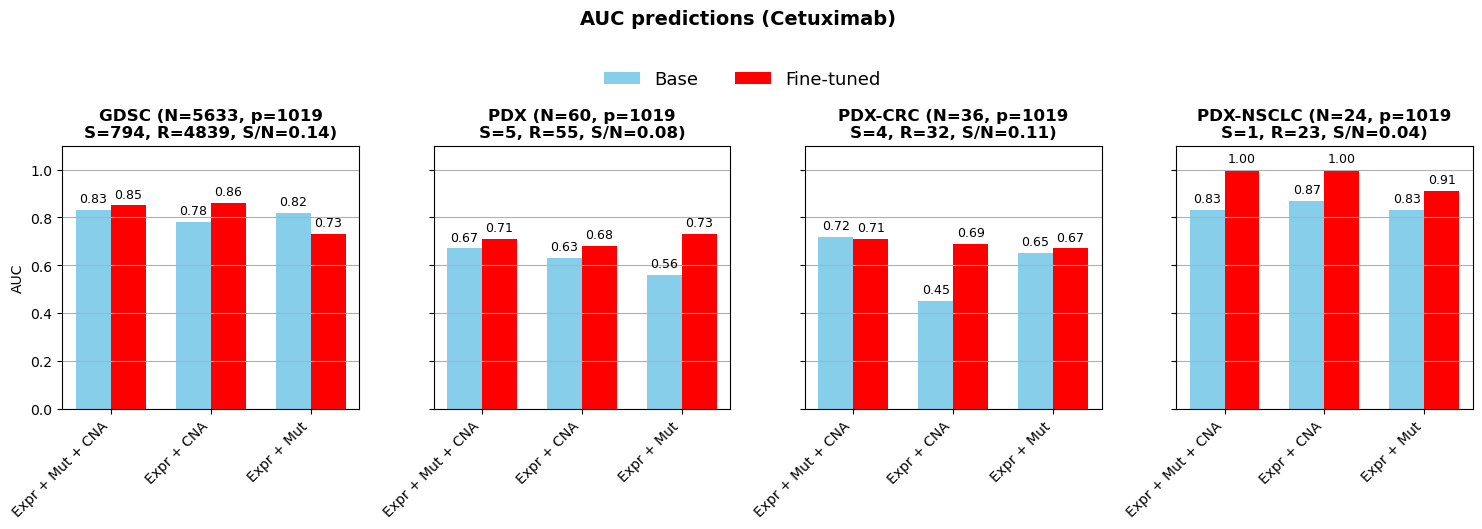

In [62]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Cetuximab)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Cetuximab).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [63]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                                 f"AUCPR (PDX, N={str(len(Ytscetuximab))})",
                                 f"AUCPR (PDX-CRC, N={str(len(Ytscetuximab_crc))})",
                                 f"AUCPR (PDX-NSCLC, N={str(len(Ytscetuximab_nsclc))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytscetuximab))})": f"PDX (N={str(len(Ytscetuximab))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRcetuximab["response"].value_counts()[1]) + ", R=" + str(PDXRcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRcetuximab["response"].value_counts()[1]/sum(PDXRcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-CRC, N={str(len(Ytscetuximab_crc))})": f"PDX-CRC (N={str(len(Ytscetuximab_crc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-NSCLC, N={str(len(Ytscetuximab_nsclc))})": f"PDX-NSCLC (N={str(len(Ytscetuximab_nsclc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()), 2)) + ")",        
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=5633, p=1019\nS=794, R=4839, S/N=0.14)","PDX (N=60, p=1019\nS=5, R=55, S/N=0.08)","PDX-CRC (N=36, p=1019\nS=4, R=32, S/N=0.11)","PDX-NSCLC (N=24, p=1019\nS=1, R=23, S/N=0.04)"
Data,,,,
Expr + Mut + CNA,0.47,0.15,0.33,0.2
Expr + Mut + CNA (Fine-tuned),0.5,0.19,0.33,1.0
Expr + CNA,0.34,0.15,0.12,0.25
Expr + CNA (Fine-tuned),0.5,0.41,0.4,1.0
Expr + Mut,0.4,0.11,0.18,0.2
Expr + Mut (Fine-tuned),0.36,0.21,0.3,0.33


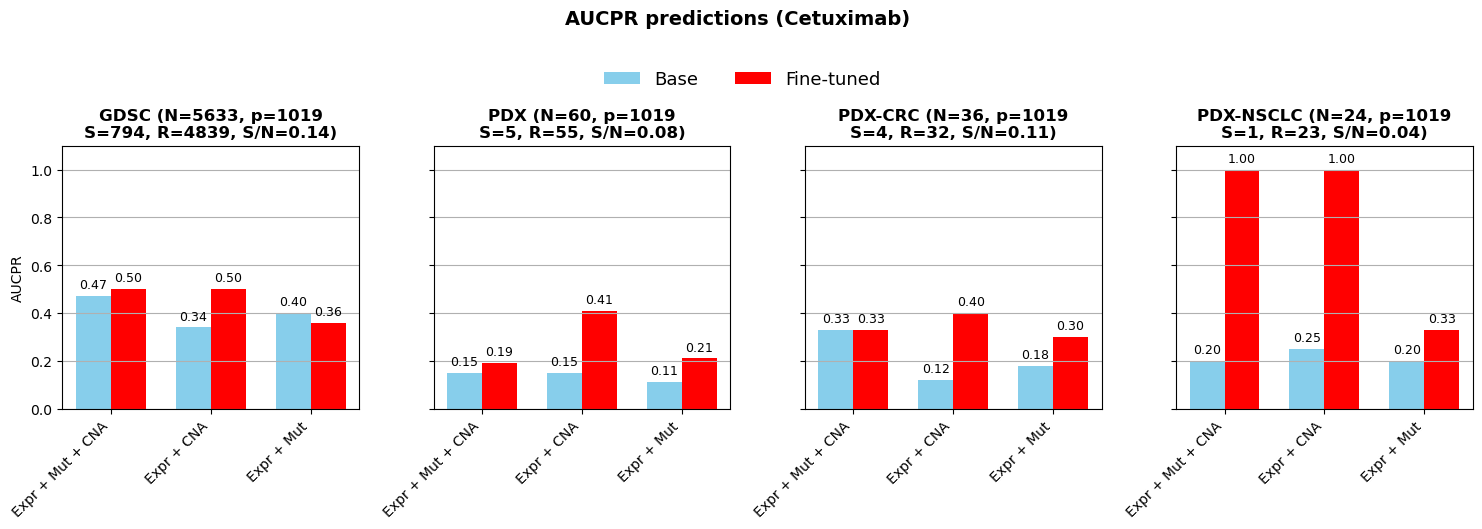

In [64]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Cetuximab)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Cetuximab).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [65]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_CNA/Predictions


In [66]:
# save predictions

file = open('GDSC_PDX_DEGs - PDX_EGFRi_Cetuximab Predictions (Expression and CNA).txt', 'w')
file.write(f"GDSC Training (EC) AUC (PDX_EGFRi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EC) AUCPR (PDX_EGFRi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EC) AUC (Cetuximab): {round(AUCTcetuximab,2)}\n")
file.write(f"PDX Test (EC) AUCPR (Cetuximab): {round(AUCTcetuximab_aucpr,2)}\n\n")

file.close()